<a href="https://colab.research.google.com/github/prabal5ghosh/research-project-on-physics-informed-machine-learning-on-transcriptomics-data/blob/main/pinn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras import layers

print(tf.__version__)
print(keras.__version__)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 0: Loss = 66.06360626220703
Epoch 100: Loss = 24.003042221069336
Epoch 200: Loss = 22.944149017333984
Epoch 300: Loss = 22.299835205078125
Epoch 400: Loss = 21.54697036743164
Epoch 500: Loss = 20.688331604003906
Epoch 600: Loss = 19.841533660888672
Epoch 700: Loss = 19.078115463256836
Epoch 800: Loss = 18.32584571838379
Epoch 900: Loss = 17.47959327697754
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


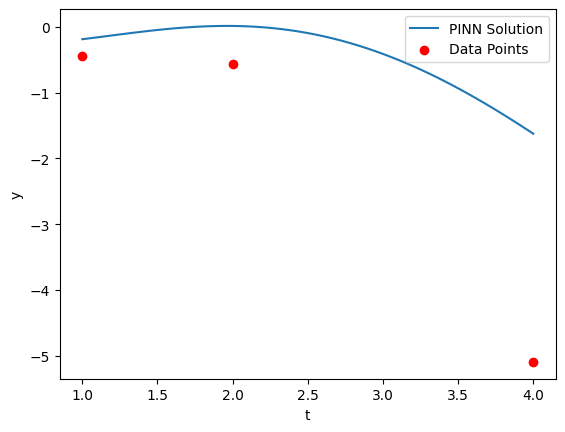

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Define constants
c_value = 0  # Assume c = 0 for simplicity
a_value = 0.1178 * c_value + 1.267
b_value = -2.2619 * c_value - 5.125

# Define time domain
t_min, t_max = 1, 4
t_train = np.linspace(t_min, t_max, 100).reshape(-1, 1)

# Neural network model
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(1,)),
    layers.Dense(20, activation='tanh'),
    layers.Dense(20, activation='tanh'),
    layers.Dense(1)
])

# Physics-Informed Loss function
def pinn_loss(t, y_true):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        y_pred = model(t)
        dy_dt = tape.gradient(y_pred, t)
    d2y_dt2 = tape.gradient(dy_dt, t)
    del tape
    physics = d2y_dt2 + a_value * dy_dt + b_value * y_pred - c_value
    physics_loss = tf.reduce_mean(tf.square(physics))
    boundary_loss = tf.reduce_mean(tf.square(model(np.array([[1.0]])) - -0.44796)) + \
                    tf.reduce_mean(tf.square(model(np.array([[2.0]])) - -0.56015)) + \
                    tf.reduce_mean(tf.square(model(np.array([[4.0]])) - -5.09196))
    return physics_loss + boundary_loss

# Training loop
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = pinn_loss(tf.convert_to_tensor(t_train, dtype=tf.float32), None)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training the PINN
epochs = 1000
for epoch in range(epochs):
    loss = train_step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")

# Predictions
t_test = np.linspace(t_min, t_max, 100).reshape(-1, 1)
y_pred = model.predict(t_test)

# Plot the result
import matplotlib.pyplot as plt
plt.plot(t_test, y_pred, label='PINN Solution')
plt.scatter([1, 2, 4], [-0.44796, -0.56015, -5.09196], color='red', label='Data Points')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()


In [7]:
import tensorflow as tf
import numpy as np

# Define the PINN architecture for the ODE system
class GeneExpressionPINN(tf.keras.Model):
    def __init__(self, num_layers=5, num_neurons=50):
        super(GeneExpressionPINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(num_neurons, activation='tanh') for _ in range(num_layers)]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, t, X):
        # Reshape t to match the shape of X (i.e., repeating t for each gene)
        t_reshaped = tf.reshape(t, (-1, 1))  # Shape: (3, 1)
        t_reshaped = tf.tile(t_reshaped, [1, X.shape[0]])  # Shape: (3, 5)

        # Transpose X to match the time dimension in the next step
        X_transposed = tf.transpose(X)  # Shape: (3, 5)

        # Concatenate time and gene expressions (now both have shape (3, 5))
        x = tf.concat([t_reshaped, X_transposed], axis=1)  # Shape: (3, 10)

        # Feed through hidden layers
        for layer in self.hidden_layers:
            x = layer(x)

        # Output layer
        return self.output_layer(x)

# Define ODE residual function (example: exponential decay for gene expression)
def ode_residual(model, t, X):
    dx_dt = model(t, X)  # Neural network's output

    # Define a simple ODE for gene expression: exponential decay (e.g., dx/dt = -k*x)
    k = 0.1  # decay constant (adjust as needed)
    # Reshape dx_dt to match the shape of X_transposed for subtraction
    dx_dt = tf.transpose(dx_dt) # Now shape: (5, 3) or (num_genes, num_time_points)

    X_reshaped = tf.reshape(X, [-1, 1])  # Reshape X to ensure compatibility for multiplication
    X_repeated = tf.tile(X_reshaped, [1, t.shape[0]])  # Shape: (5, 3)

    # Assume each gene decays exponentially with rate k
    dx_dt_exact = -k * X_repeated  # Shape: (5, 3)

    return tf.reduce_mean(tf.square(dx_dt - dx_dt_exact))

# Data (your provided gene expression values)
time_points = np.array([1, 2, 4])  # days
gene_data = {
    'AT2G38470': [0.906, 0.906, 0.906],
    'AT5G40100': [-0.448, -0.560, -5.092],
    'AT1G06930': [1.778, 0, 0],
    'AT1G04470': [0, 1.175, 0],
    'AT5G66730': [0.055, 0.098, -0.102]
}

# Convert to TensorFlow format
time_tensor = tf.convert_to_tensor(time_points, dtype=tf.float32)
expression_tensor = tf.convert_to_tensor(list(gene_data.values()), dtype=tf.float32)

# Initialize and train the PINN
model = GeneExpressionPINN()
optimizer = tf.optimizers.Adam()

# Training loop
for epoch in range(1000):
    with tf.GradientTape() as tape:
        loss = ode_residual(model, time_tensor, expression_tensor)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# After training, use the model to predict the gene expression for new time points
predicted_expression = model(time_tensor, expression_tensor)


Epoch 0, Loss: 0.06098169833421707
Epoch 100, Loss: 0.02230748161673546
Epoch 200, Loss: 0.022307127714157104
Epoch 300, Loss: 0.022307131439447403
Epoch 400, Loss: 0.022307131439447403
Epoch 500, Loss: 0.022307127714157104
Epoch 600, Loss: 0.022307131439447403
Epoch 700, Loss: 0.022307131439447403
Epoch 800, Loss: 0.022307127714157104
Epoch 900, Loss: 0.022307131439447403


In [12]:
import torch
import torch.nn as nn

class ODENet(nn.Module):
    def __init__(self):
        super(ODENet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 5)  # Output layer with 5 neurons
        )

    def forward(self, t):
        return self.net(t)


In [13]:
def ode_loss(model, t, y_true):
    y_pred = model(t)

    # Reshape y_pred and y_true to have the same shape
    y_pred = y_pred.transpose(0, 1)  # Transpose to shape (5, 3)

    # Data loss
    loss_data = torch.mean((y_pred - y_true)**2)

    # Physics loss (approximating derivatives)
    dt = 0.01
    t_prev = t - dt
    t_next = t + dt
    y_prev = model(t_prev)
    y_next = model(t_next)
    dy_dt = (y_next - y_prev) / (2 * dt)

    # Define your ODE here (example: dy/dt = -y)
    # NOTE: You may need to adjust this part to match your actual ODE
    ode_residual = dy_dt + y_pred.transpose(0, 1)  # Transpose back for physics loss calculation
    loss_physics = torch.mean(ode_residual**2)

    return loss_data + loss_physics

In [14]:
import numpy as np

# Prepare data
data = np.array([
    [0.906000416, 0.906000416, 0.906000416],
    [-0.44796003, -0.560154646, -5.091964284],
    [1.778358524, 0, 0],
    [0, 1.175149691, 0],
    [0.055374646, 0.098434984, -0.101756864]
])
t_data = torch.tensor([1, 2, 4], dtype=torch.float32).unsqueeze(1)
y_data = torch.tensor(data, dtype=torch.float32)

model = ODENet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    loss = ode_loss(model, t_data, y_data)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 2.840717315673828
Epoch 1000, Loss: 0.004493011627346277
Epoch 2000, Loss: 3.104556162725203e-05
Epoch 3000, Loss: 3.4071561572091014e-08
Epoch 4000, Loss: 4.015223709075144e-08
Epoch 5000, Loss: 7.315097860782771e-08
Epoch 6000, Loss: 1.9755521663000764e-08
Epoch 7000, Loss: 5.38489839527756e-05
Epoch 8000, Loss: 0.00013225345173850656
Epoch 9000, Loss: 1.0314930420918245e-07


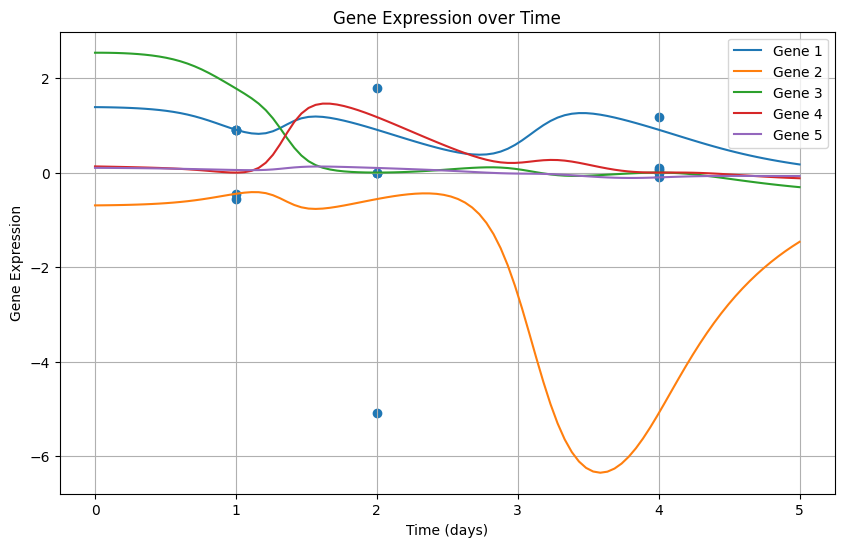

In [16]:
import matplotlib.pyplot as plt

t_plot = torch.linspace(0, 5, 100).unsqueeze(1)
y_plot = model(t_plot).detach().numpy()

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(t_plot, y_plot[:, i], label=f"Gene {i+1}")

# Repeat t_data for each gene and flatten y_data
t_scatter = np.repeat(t_data.numpy().squeeze(), y_data.shape[0])
y_scatter = y_data.numpy().flatten()

plt.scatter(t_scatter, y_scatter, marker='o')  # Updated scatter plot
plt.xlabel("Time (days)")
plt.ylabel("Gene Expression")
plt.legend()
plt.title("Gene Expression over Time")
plt.grid(True)
plt.show()